# Base

In [4]:
import os
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image
import cv2
import joblib

from sklearn.cluster import KMeans, MiniBatchKMeans
from scipy.cluster.vq import vq

np.random.seed(0)  # reproducibility
root_dir = '/teamspace/studios/this_studio/dataset/labeled-images'
ckpt_path = './checkpoints'

os.makedirs(ckpt_path, exist_ok=True)
os.makedirs(f'{ckpt_path}/descriptors/', exist_ok=True)
os.makedirs(f'{ckpt_path}/codebook/', exist_ok=True)
os.makedirs(f'{ckpt_path}/embedding_df/', exist_ok=True)

s_id = np.random.randint(0, 100)

# BoVW class

In [ ]:
from typing import Optional

class BagOfVisualWords:
    def __init__(
        self,
        root_dir: str = "/kaggle/input/the-hyper-kvasir-dataset/labeled_images",
        descriptors_lake_path: str = None,
        codebook_dir: str = None,
        
        method: str = 'sift',
        extractor_kwargs: dict = None,
    ):
        """Constructor method
        
        :param descriptors_lake_path: str (optional), path to file including all computed descriptors (vectors)
        :param codebook_dir: str (optional), path to visual vocabulary
        
        """
        self.root_dir = root_dir
        self.df = pd.read_csv(f"{root_dir}/image-labels.csv")
        self.labels = tuple(self.df["Finding"].unique())
        
        # In reality in building codebook, choose small sample size idx for efficient 
        self.samples_idx = []  

        # ------ extracting algorithms --------
        self.method = method
        if method == "sift":
            self.extractor = cv2.SIFT_create()
        elif method == "orb":
            self.extractor = cv2.ORB_create(**extractor_kwargs)
        elif method == "surf":
            self.extractor = cv2.xfeatures2d.SURF_create(**extractor_kwargs)
        else:
            raise ValueError(f"Unsupported feature extracting method: {method}")
            
    def extract_descriptors(self, sample_size: int = 2000,
                                grayscale: bool = True,
                                strongest_percent: float = 1,
                                **extractor_kwargs
                        ) -> np.array:
        """Extract descriptors from sample_size images
        :param method: str, method to extract feature descriptors e.g. ORB, SIFT, SURF, etc
        :param sample_size: size of sample. (We likely use a small sample in real-world scenario,
            where whole dataset is big)
        :param grayscale: bool - if True, convert to gray for efficient computing
        :param strongest_percent: float - get % percent of strongest (based on .response of keypoints)
        descriptors.  

        :return: list, n descriptors x sample_size images

        # TODO: sample for building visual vocabulary must be balance between classes
        every class include at least one image
        """
        # ------- Sampling -----------
        self.sample_idx = np.random.choice(np.arange(0, len(self.df)),
                                            size=sample_size,
                                            replace=False
                                        ).tolist() #  randomly sample sample_size images

        descriptors_sample_all = (
            []
        )  # each image has many descriptors, descriptors_sample_all
        # is a list of all descriptors of sample_size images

        # loop each image > extract > append
        for idx in tqdm(self.sample_idx):
            img_keypoints, img_descriptors = self._get_descriptors_one_img(idx)
            if img_descriptors is not None:
                # filter top_percent strongest keypoint
                sorted_couple = sorted(zip(img_keypoints, img_descriptors), key=lambda x: x[0].response, reverse=True)
                img_keypoints, img_descriptors = zip(*sorted_couple) # unzip
                top = int(len(img_keypoints) * strongest_percent)
                top_descriptors = img_descriptors[:top]               

                for descriptor in top_descriptors:
                    descriptors_sample_all.append(np.array(descriptor))

        # convert to single numpy array
        descriptors_sample_all = np.stack(descriptors_sample_all)

        return descriptors_sample_all

    def build_codebook(
        self,
        descriptors_lake: np.array,
        cluster_algorithm: str = 'kmean',
        k: int = 200,
        batch_size = 1000,
        n_init: int = 10
    ) -> np.array:
        """Building visual vocabulary (visual words)
        :param descriptors_lake: array of descriptors
        :param cluster_algorithm: type of cluster algorithm like K-mean, Birch
        :param k: #cluster (centroids)
        
        :return: #centroids, codebook

        """
        if cluster_algorithm == 'kmean':
            cluster_model = MiniBatchKMeans(n_clusters=k,
                                            batch_size=batch_size,
                                            random_state=123,
                                            n_init=n_init)

        # n_batches = int(len(descriptors_lake) / batch_size)
        for _ in tqdm(range(n_init), desc='Initializing'):
            cluster_model.partial_fit(descriptors_lake)

        # Final clustering
        cluster_model.fit(descriptors_lake)
        return cluster_model.cluster_centers_
    
    # ------------------------ for inference ----------------------------
    def get_embedding(
        self,
        idx: int,
        codebook: np.ndarray,
        normalized: bool = False,
        tfidf: bool = False
    ) -> np.ndarray:
        """Get embeddings of image[idx] (image > descriptors > projection in codebook > frequencies vectors)
        :param idx: int, image index
        :param codebook: np.ndarray, visual vocabulary
        :param normalized: bool, if True, normalize embedding in scale [0, 1]
        
        :return: np.array, frequencies vector (can consider as embedding)
        """
        _, img_descriptors = self._get_descriptors_one_img(idx)
        img_visual_words, distance = vq(img_descriptors, codebook)
        img_frequency_vector = np.histogram(
            img_visual_words, bins=codebook.shape[0], density=normalized
        )[0]

        if tfidf:
            # TODO
            # self._tf_idf()
            # img_frequency_vector = img_frequency_vector * self.idf
            pass
        
        return img_frequency_vector
    # ------------------------ for inference ----------------------------

    def _tf_idf(self):
        """TODO: Reweight important features in codebook"""
        self.idf = 1

        all_embeddings = []
        for i in range(len(self.df)):
            embedding = self.get_embedding(i)
            all_embeddings.append(embedding)

        all_embeddings = np.stack(all_embeddings)

        N = len(self.df)
        df = np.sum(all_embeddings > 0, axis=0)
        idf = np.log(N / df)

        return idf

    def _get_item(self, idx) -> tuple:
        """Return pair (image(arr), label)
        :param idx: index of data

        :return: tuple, (image: np.array, label)
        """
        # get path of image
        GI_dir = {"Lower GI": "lower-gi-tract", "Upper GI": "upper-gi-tract"}

        img = self.df["Video file"][idx]
        gi_tract = GI_dir[self.df["Organ"][idx]]
        classification = self.df["Classification"][idx]
        finding = self.df["Finding"][idx]
        path = f"""{self.root_dir}/{gi_tract}/{classification}/{finding}/{img}.jpg"""
        assert (
            os.path.exists(path) == True
        ), f"{path} does not exist"  # dir existance checking

        # read image
        image = np.array(Image.open(path))
        label = self.labels.index(finding)

        return image, label
    
    def _get_descriptors_one_img(self, idx, grayscale=True):
        """Extracting descriptors for each image[idx]
        :param method: method to extract features e.g. ORB, SIFT, SURF, etc
        :param idx: image index

        :return: descriptors
        :rtype: np.array
        """
        # get image
        img, _ = self._get_item(idx)
        # preprocessing: convert to grayscale for efficient computing
        if len(img.shape) == 3 and grayscale:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # descriptors extracting
        img_keypoints, img_descriptors = self.extractor.detectAndCompute(img, None)

        return img_keypoints, img_descriptors


# Pipeline

# 1. extracting descriptors

In [ ]:
'''hyperparameters'''
method = 'sift'
sample_size = 20 # test
strongest_percent = 1
'''hyperparameters'''

# ----- 1. extracting descriptors -------------
model = BagOfVisualWords(
        root_dir=root_dir,
        method=method
    )
descriptors_lake = model.extract_descriptors(sample_size=sample_size,
                                            strongest_percent=strongest_percent)
print('='*20, 'Completely extracting descriptors', '='*20)

# =========== saving descriptors lake ===============
descriptors_lake_path = joblib.dump(descriptors_lake,
                                    f'{ckpt_path}/descriptors/id{s_id}-{sample_size}_img-{model.method}_extractor-{strongest_percent*100}%_strongest.pkl',
                                    compress=3)
# =================== free memory here ====================
del descriptors_lake
# =================== free memory here ====================

# =================== load ================================
descriptors_lake = joblib.load(*descriptors_lake_path) # unpack list
descriptors_lake.shape

# 2. Building codebook

In [ ]:
'''hyperparameters'''
k = 200 # #cluster = vector size
cluster_algorithm='kmean'
'''hyperparameters'''

# ------- 2. building visual vocabulary -----------
codebook = model.build_codebook(descriptors_lake=descriptors_lake,
                                    cluster_algorithm='kmean',
                                    k=200
                                )
print('='*20, 'Completely building codebook', '='*20)

# =========== saving descriptors lake ===============
codebook_path = joblib.dump(codebook,
                            f'{ckpt_path}/codebook/id{s_id}-{cluster_algorithm}_cluster_algorithm-k={k}.pkl',
                            compress=3)
# =================== free memory here ====================
del descriptors_lake
del codebook
# =================== free memory here ====================

# =================== load codebook ================================
codebook = joblib.load(*codebook_path) # unpack list
codebook.shape

# 3. Embedding representation

# 4. Classification

### Get embeddings
- img -> codebook -> embedding

In [ ]:
method='sift'
model = BagOfVisualWords(
        root_dir=root_dir,
        method=method
    )

# =================== load codebook ================================
codebook = joblib.load(*codebook_path) # unpack list

# ---------- hyperparams -----------------
normalized=False
# ---------- hyperparams -----------------

embedding = model.get_embedding(0, codebook, normalized=normalized)
plt.bar(list(range(len(embedding))),embedding)

### Formating for classification

In [ ]:
# ---------- hyperparams -----------------
normalized=False
# ---------- hyperparams -----------------

headers = [f'feature{i}' for i in range(codebook.shape[0])]
embedding_df = pd.DataFrame(columns=headers)
labels = []

# Embedding entire dataset
for idx in tqdm(range(len(model.df))):
    img, label = model._get_item(idx)
    embedding = model.get_embedding(idx, codebook, normalized=normalized)
    # Add a row to the DataFrame
    embedding_df.loc[len(embedding_df)] = embedding
    labels.append(label)
    # break

embedding_df['label'] = pd.Series(labels, dtype='int')

embedding_df.to_csv(f'{ckpt_path}/embedding_df/id{s_id}-{n_imgs}_img-normalized={normalized}.csv', index=False)

# =================== free memory here ====================
del embedding_df
# =================== free memory here ====================

### Load data and EDA

In [2]:
# 1. Load dataset
df = pd.read_csv('/teamspace/studios/this_studio/checkpoints/embedding_df/id44-100_img-normalized=False.csv')

X = df.drop('label', axis=1)
y = df['label']

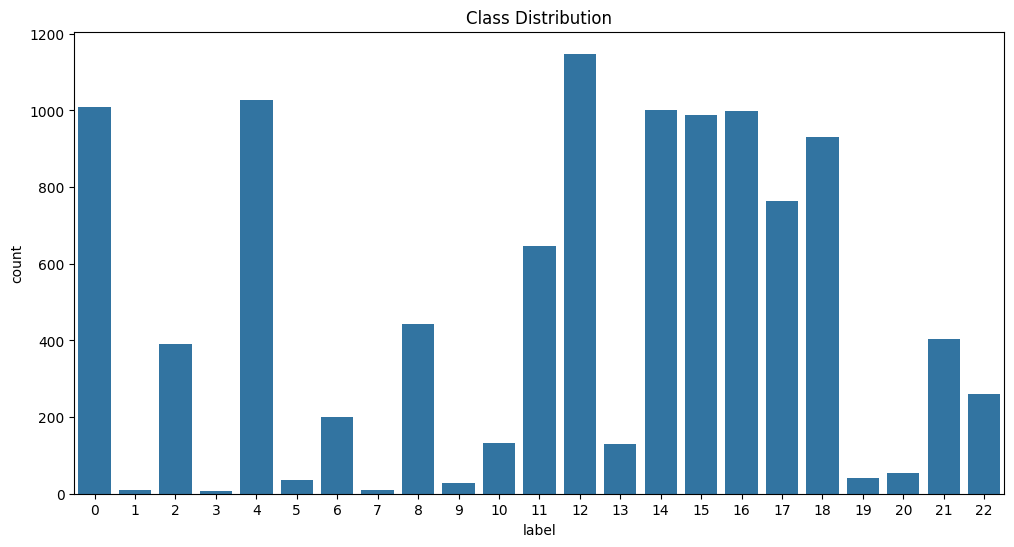

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.countplot(x='label', data=df)
plt.title('Class Distribution')
plt.show()

label
12    10.767211
4      9.641718
0      9.463515
14     9.397862
16     9.369724
15     9.275933
18     8.741324
17     7.165635
11     6.058901
8      4.154943
21     3.779779
2      3.667229
22     2.438567
6      1.885200
10     1.247421
13     1.228663
20     0.497092
19     0.384543
5      0.328269
9      0.262615
7      0.103170
1      0.084412
3      0.056275
Name: count, dtype: float64

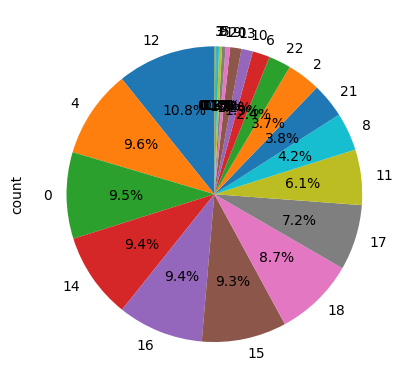

In [4]:
label_distribution = df['label'].value_counts()
label_distribution.plot(kind="pie", autopct="%1.1f%%", startangle=90)
label_distribution / len(df) * 100

#### Heatmap

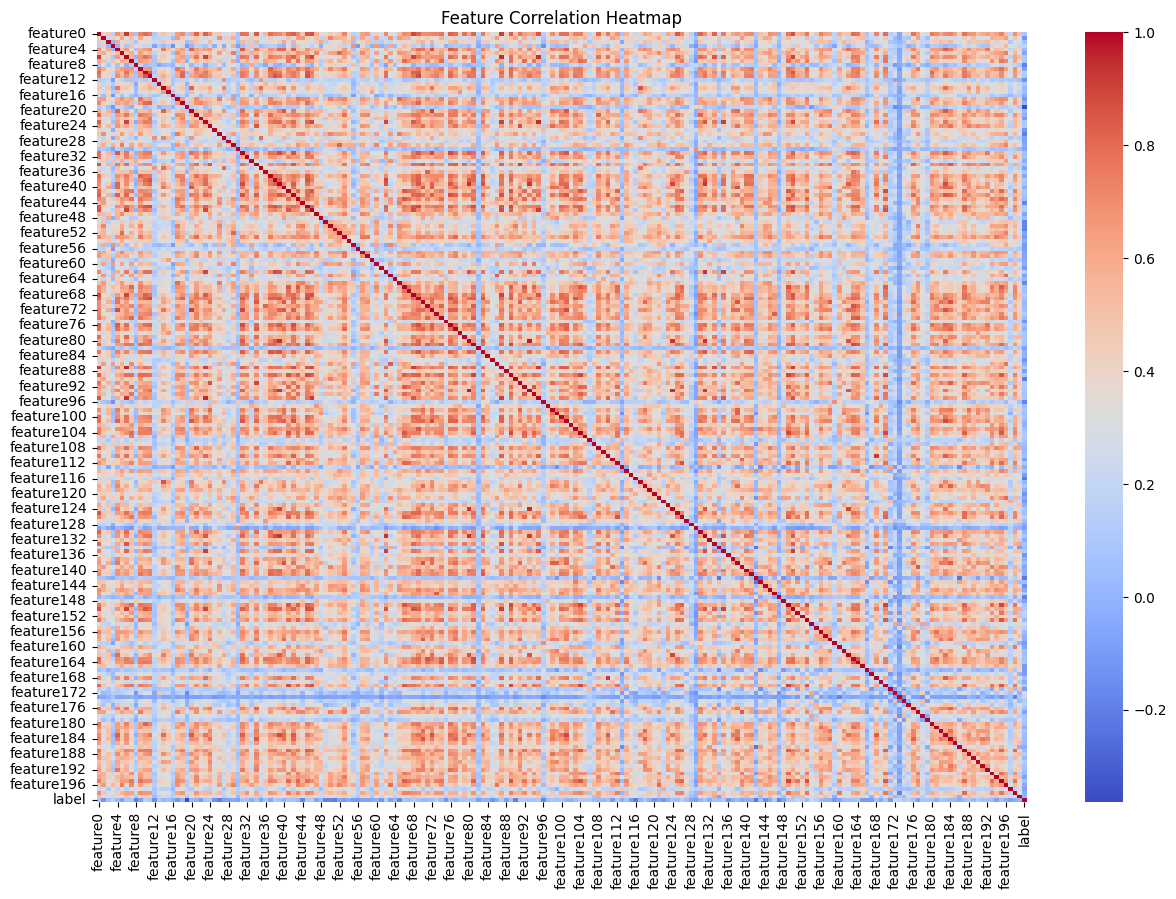

In [5]:
corr = df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

#### Feature distribution

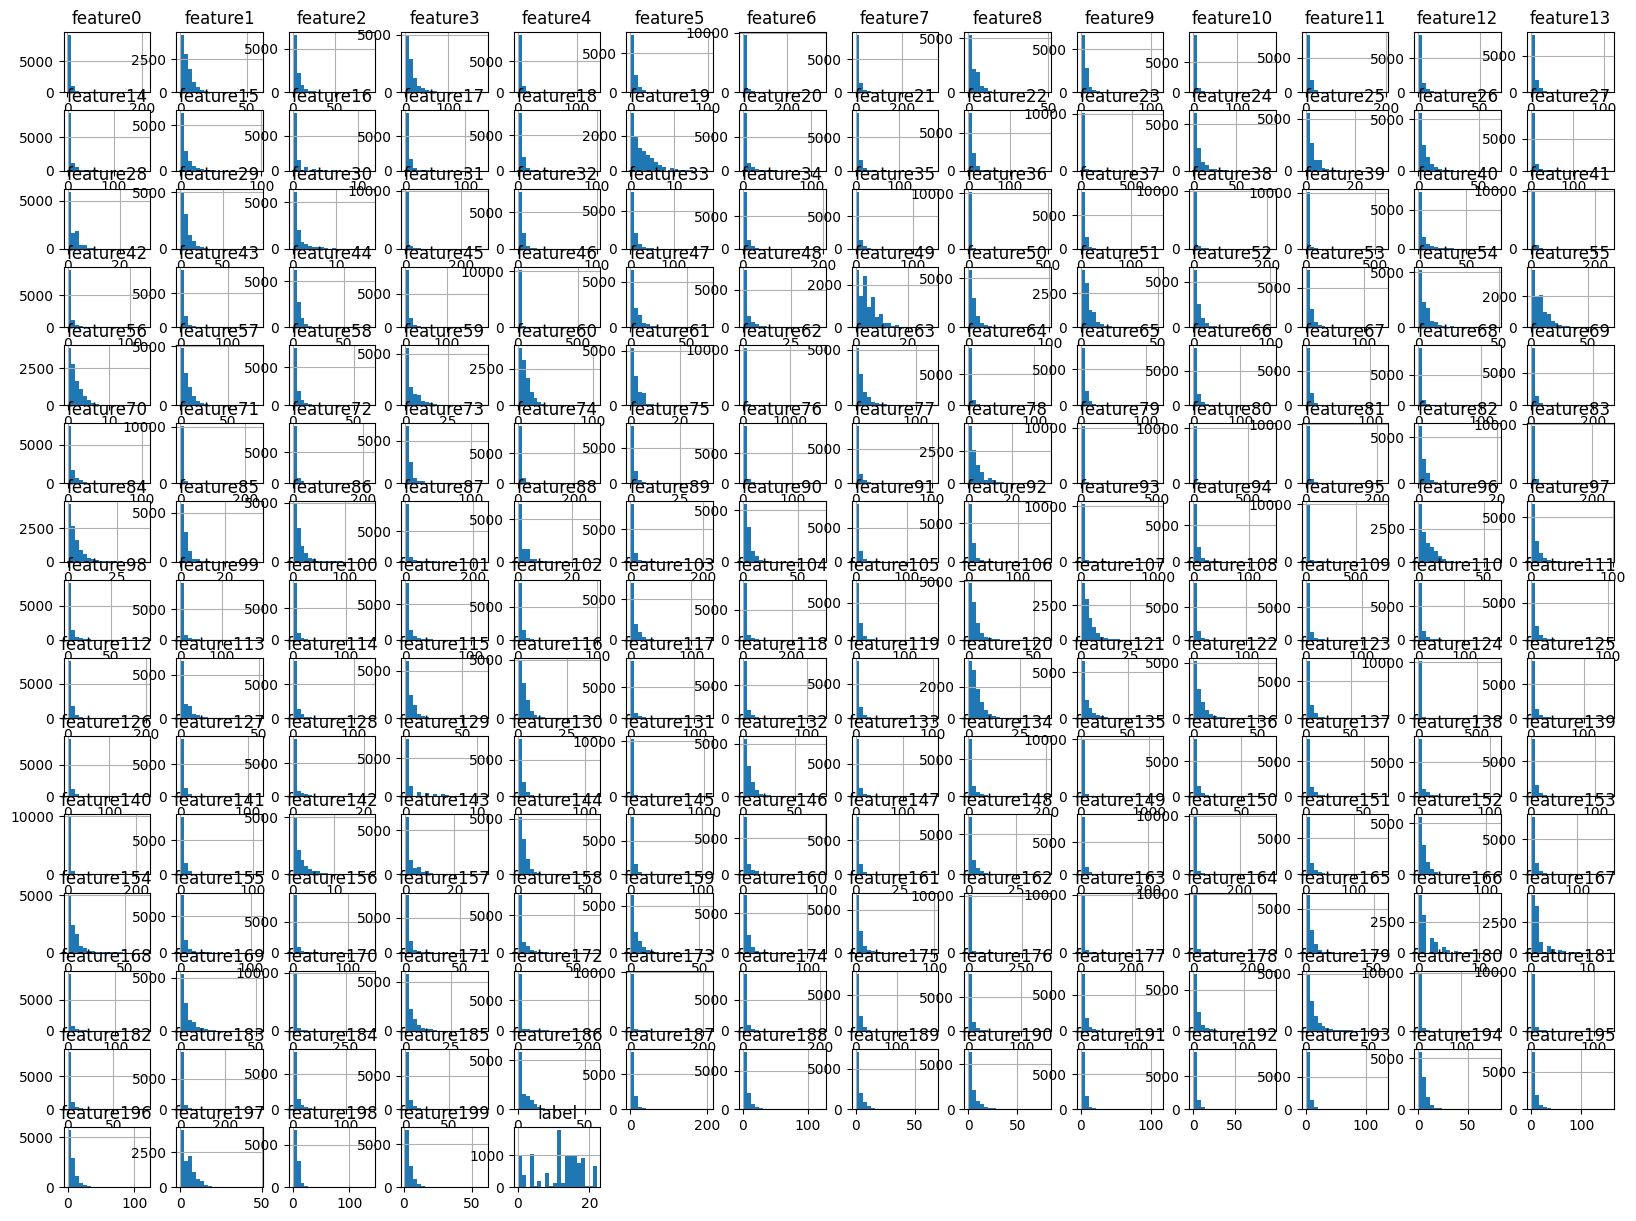

In [6]:
df.hist(bins=20, figsize=(20, 15))
plt.show()

## Model development and evaluation

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

# classifier: hyperparams
model = RandomForestClassifier(class_weight='balanced', random_state=42)

In [60]:
# Set up Stratified K-Fold cross-validation
kf = StratifiedKFold(n_splits=5)

# Lists to store metric results
precision_macro_scores = []
precision_micro_scores = []
recall_macro_scores = []
recall_micro_scores = []
f1_macro_scores = []
f1_micro_scores = []
balanced_accuracy_scores = []

# Cross-validation loop
for train_index, test_index in tqdm(kf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # # Preprocessing - hyperparams
    # scaler = StandardScaler()
    # X = scaler.fit_transform(X)

    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the test fold
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    precision_macro = precision_score(y_test, y_pred, average='macro')
    precision_micro = precision_score(y_test, y_pred, average='micro')
    recall_macro = recall_score(y_test, y_pred, average='macro')
    recall_micro = recall_score(y_test, y_pred, average='micro')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_micro = f1_score(y_test, y_pred, average='micro')
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

    # Store metrics for this fold
    precision_macro_scores.append(precision_macro)
    precision_micro_scores.append(precision_micro)
    recall_macro_scores.append(recall_macro)
    recall_micro_scores.append(recall_micro)
    f1_macro_scores.append(f1_macro)
    f1_micro_scores.append(f1_micro)
    balanced_accuracy_scores.append(balanced_accuracy)

    # # Print classification report for each fold
    # print(f"Classification Report for Fold {len(precision_macro_scores)}:")
    # print(classification_report(y_test, y_pred))
    # print("\n")
    
# Calculate and print the average metrics across all folds
print("Average Metrics Across All Folds:")
print('\n', "="*50, '\n')
print("Precision (Macro):", np.mean(precision_macro_scores))
print("Recall (Macro):", np.mean(recall_macro_scores))
print("F1-Score (Macro):", np.mean(f1_macro_scores))
print('\n', "="*50, '\n')
print("Precision (Micro):", np.mean(precision_micro_scores))
print("Recall (Micro):", np.mean(recall_micro_scores))
print("F1-Score (Micro):", np.mean(f1_micro_scores))
print('\n', "="*50, '\n')
print("Balanced Accuracy:", np.mean(balanced_accuracy_scores))


0it [00:00, ?it/s]/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
1it [00:05,  5.15s/it]/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2it [00:10,  5.15s/it]/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

Average Metrics Across All Folds:


Precision (Macro): 0.3769571603073635
Recall (Macro): 0.30084038060544466
F1-Score (Macro): 0.299742686911692


Precision (Micro): 0.5741892568227855
Recall (Micro): 0.5741892568227855
F1-Score (Micro): 0.5741892568227855


Balanced Accuracy: 0.30084038060544466


In [ ]:
# Calculate and print the average metrics across all folds
print("Average Metrics Across All Folds:")
print('\n', "="*50, '\n')
print("Precision (Macro):", np.mean(precision_macro_scores))
print("Recall (Macro):", np.mean(recall_macro_scores))
print("F1-Score (Macro):", np.mean(f1_macro_scores))
print('\n', "="*50, '\n')
print("Precision (Micro):", np.mean(precision_micro_scores))
print("Recall (Micro):", np.mean(recall_micro_scores))
print("F1-Score (Micro):", np.mean(f1_micro_scores))
print('\n', "="*50, '\n')
print("Balanced Accuracy:", np.mean(balanced_accuracy_scores))

## AutoML

In [15]:
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, make_scorer, f1_score

# 1. Load dataset
df = pd.read_csv('/teamspace/studios/this_studio/checkpoints/embedding_df/id44-100_img-normalized=False.csv')

X = df.drop('label', axis=1)
y = df['label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define a custom scoring function (e.g., F1 macro)
f1_macro_scorer = make_scorer(f1_score, average='macro')

# Set up TPOT with the custom scorer
tpot = TPOTClassifier(generations=5, population_size=20, scoring=f1_macro_scorer, cv=5, random_state=42, verbosity=2)

In [16]:
tpot.fit(X_train, y_train)

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]

In [ ]:
tpot.fit(X_train, y_train)

# Export the best model
tpot.export('best_model_pipeline.py')


# Test

In [ ]:

# =========== Sanity check =================================
# ====================== Unit tests =================================================
def test_attributes():
    assert model.df.shape == (10662, 4)  # dataframe
    assert len(model.labels) == 23  # #labels


# test _get_item method
def test_get_item():
    image, label = model._get_item(0)
    assert len(image.shape) == 3  # image is a 3-dimensional array (h, w, c)
    assert type(label) == int and 0 <= label <= 22  # label


# test _get_descriptors method
def test_get_descriptors():
    img_descriptors = model._get_descriptors(0)
    assert len(img_descriptors.shape) == 2


# test extract all descriptors process method
def test_extract_desciptors():
    # descriptors_lake = model.extract_descriptors() # ensure output is 2d
    assert len(model.descriptors_lake.shape) == 2, "Invalid extracting process"
    # assert len(model.sample_idx) == 1000, 'Invalid sampling'


# test build_codebook method
def test_build_codebook():
    assert model.codebook.shape == (model.k, 128), "Invalid building codebook process"


# test get_embedding method
def test_get_embedding():
    embedding = model.get_embedding(0)
    assert embedding.shape[0] == model.k
    
test_attributes()
test_get_item()
test_get_descriptors()
# test_extract_desciptors()
test_build_codebook()
test_get_embedding()